In [2]:
import pandas as pd    
import numpy as np    
import matplotlib.pyplot as plt    
import seaborn as sns    
import datetime    
import warnings    
warnings.filterwarnings('ignore')

#### 1.文件读取

In [3]:
data_train = pd.read_csv('data/train.csv')
data_test_a = pd.read_csv('data/testA.csv')

#### 2.原始数据观察

##### 2.1训练集个数与维度

In [4]:
data_train.shape

(800000, 47)

##### 2.2测试集个数与维度

In [5]:
data_test_a.shape

(200000, 46)

##### 2.3数据类型

In [6]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800000 entries, 0 to 799999
Data columns (total 47 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  800000 non-null  int64  
 1   loanAmnt            800000 non-null  float64
 2   term                800000 non-null  int64  
 3   interestRate        800000 non-null  float64
 4   installment         800000 non-null  float64
 5   grade               800000 non-null  object 
 6   subGrade            800000 non-null  object 
 7   employmentTitle     799999 non-null  float64
 8   employmentLength    753201 non-null  object 
 9   homeOwnership       800000 non-null  int64  
 10  annualIncome        800000 non-null  float64
 11  verificationStatus  800000 non-null  int64  
 12  issueDate           800000 non-null  object 
 13  isDefault           800000 non-null  int64  
 14  purpose             800000 non-null  int64  
 15  postCode            799999 non-nul

### 3.数据缺失值与唯一值

There are 22 columns in train dataset with missing values.


<Axes: >

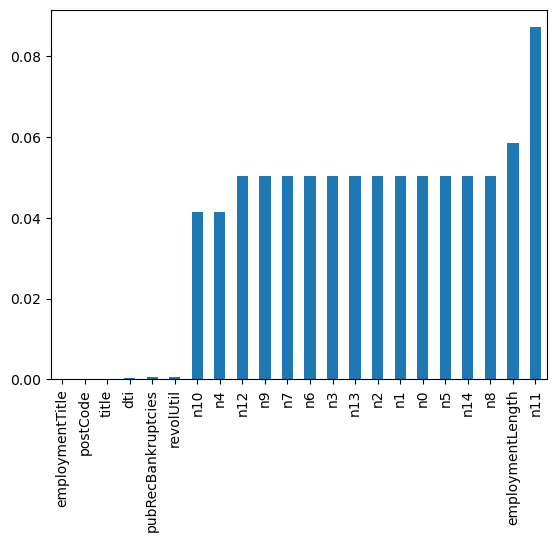

In [7]:
#总缺失值
print(f'There are {data_train.isnull().any().sum()} columns in train dataset with missing values.')
#确实率过50%的缺失值
have_null_fea_dict = (data_train.isnull().sum()/len(data_train)).to_dict()    
fea_null_moreThanHalf = {}    
for key,value in have_null_fea_dict.items():    
    if value > 0.5:    
        fea_null_moreThanHalf[key] = value
fea_null_moreThanHalf
#nan可视化    
missing = data_train.isnull().sum()/len(data_train)    
missing = missing[missing > 0]    
missing.sort_values(inplace=True)    
missing.plot.bar()

In [8]:
one_value_fea = [col for col in data_train.columns if data_train[col].nunique() <= 1]
one_value_fea_test = [col for col in data_test_a.columns if data_test_a[col].nunique() <= 1]
print(f'There are {len(one_value_fea)} columns in train dataset with one unique value.',one_value_fea)    
print(f'There are {len(one_value_fea_test)} columns in test dataset with one unique value.',one_value_fea_test)

There are 1 columns in train dataset with one unique value. ['policyCode']
There are 1 columns in test dataset with one unique value. ['policyCode']


In [9]:
#去掉唯一值与id
data_train.drop('id', axis=1, inplace = True)
data_train.drop('policyCode', axis=1, inplace = True)    

### 4. 数值特征与类别特征

In [12]:
# 两类特征进行分类
numerical_fea = list(data_train.select_dtypes(exclude=['object']).columns)                # 数值特征
category_fea = list(filter(lambda x: x not in numerical_fea, list(data_train.columns)))  # 类别特征 
 
# 将 label 去除
label = 'isDefault'
numerical_fea.remove(label)
print('There are',len(numerical_fea),'numerical features : ',numerical_fea);
print('There are',len(category_fea), 'category features : ',category_fea);

There are 39 numerical features :  ['loanAmnt', 'term', 'interestRate', 'installment', 'employmentTitle', 'homeOwnership', 'annualIncome', 'verificationStatus', 'purpose', 'postCode', 'regionCode', 'dti', 'delinquency_2years', 'ficoRangeLow', 'ficoRangeHigh', 'openAcc', 'pubRec', 'pubRecBankruptcies', 'revolBal', 'revolUtil', 'totalAcc', 'initialListStatus', 'applicationType', 'title', 'n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9', 'n10', 'n11', 'n12', 'n13', 'n14']
There are 5 category features :  ['grade', 'subGrade', 'employmentLength', 'issueDate', 'earliesCreditLine']


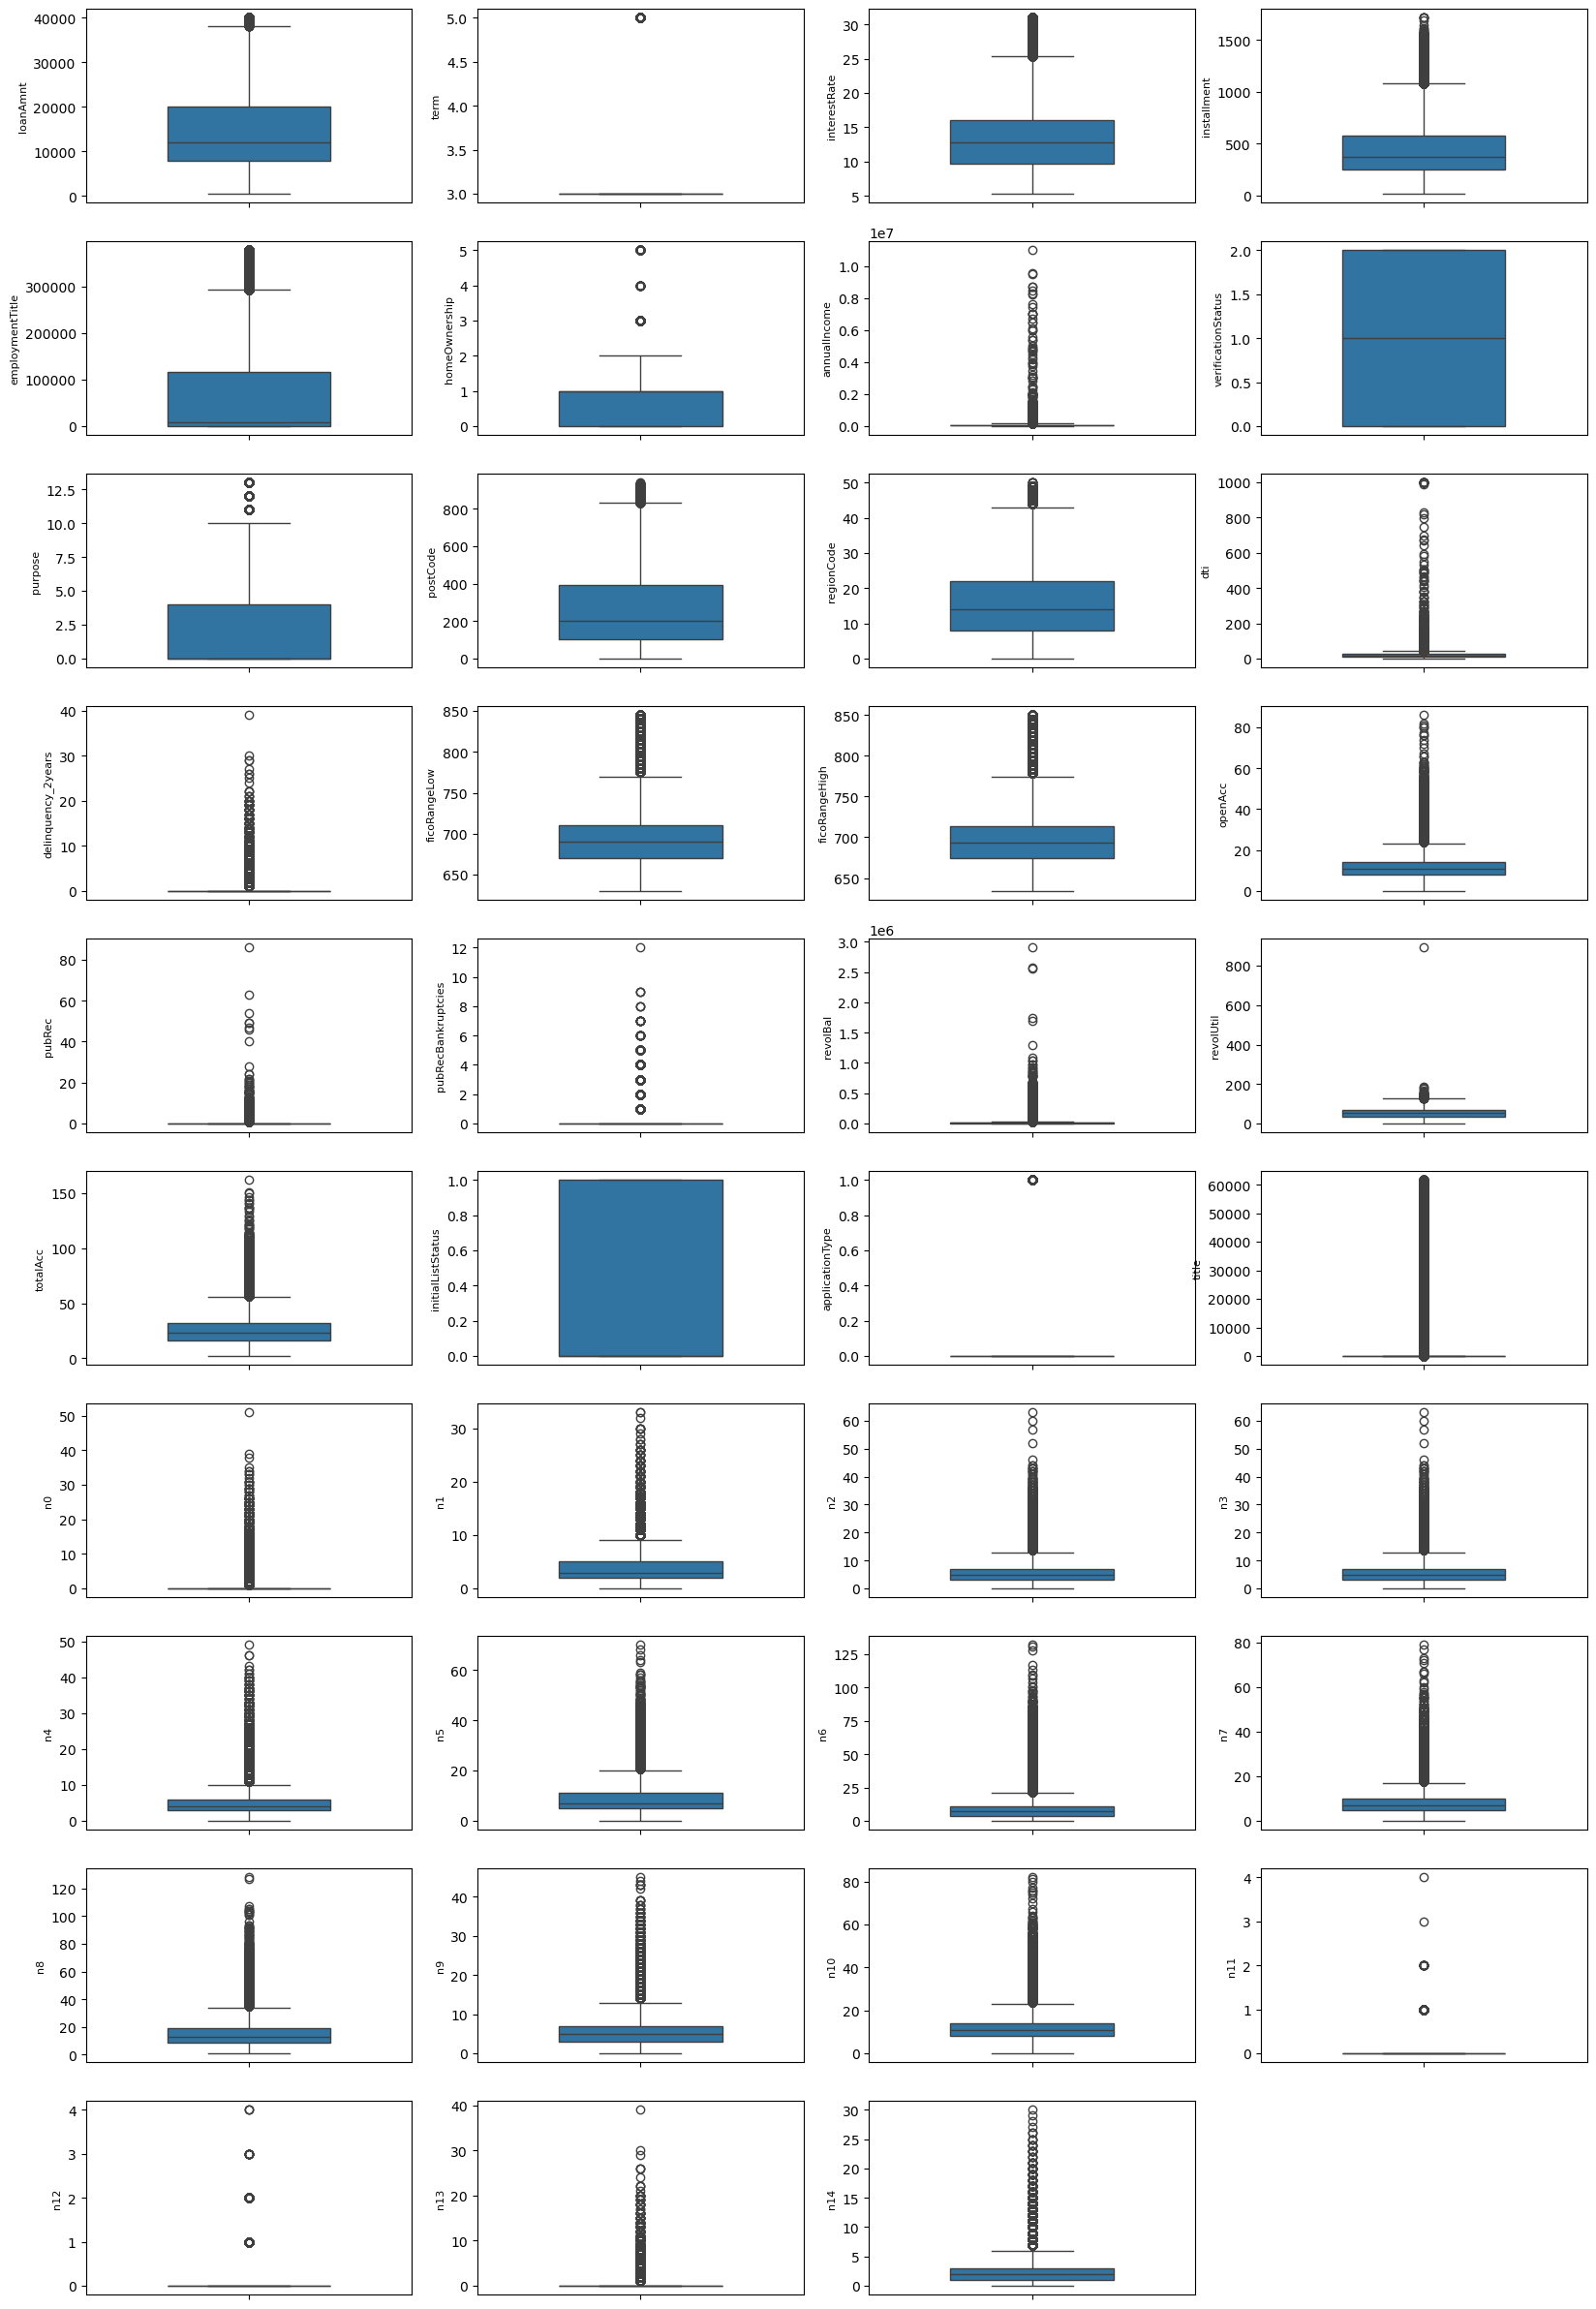

In [14]:
#对数值特征进行箱式图观察
# 画箱式图
column = numerical_fea # 列表头
fig = plt.figure(figsize=(20, 40))  # 指定绘图对象宽度和高度
for i in range(len(column)):
    plt.subplot(13, 4, i + 1)  # 13行3列子图
    sns.boxplot(data_train[column[i]], orient="v", width=0.5)  # 箱式图
    plt.ylabel(column[i], fontsize=8)
plt.show()


In [18]:
#肉眼区分连续型与非连续型变量
continuous_cols = [
    'id', 'loanAmnt', 'interestRate', 'installment', 'employmentTitle', 'homeOwnership',
    'annualIncome', 'purpose', 'postCode', 'regionCode', 'dti', 'delinquency_2years',
    'ficoRangeLow', 'ficoRangeHigh', 'openAcc', 'pubRec', 'revolBal', 'revolUtil','totalAcc',
    'title', 'n14'
] + [f'n{i}' for i in range(11)] 
non_continuous_cols = [
    x for x in numerical_fea if x not in continuous_cols
]
print('continuous cols:',continuous_cols)
print('non-continuous cols:',non_continuous_cols)
#根据算法区分
def get_numerical_serial_fea(data,feas):
    numerical_serial_fea = []                 # 连续变量
    numerical_noserial_fea = []               # 离散变量
    for fea in feas:
        temp = data[fea].nunique()
        if temp <= 10:
            numerical_noserial_fea.append(fea)
        else:
            numerical_serial_fea.append(fea)
    return numerical_serial_fea,numerical_noserial_fea
numerical_serial_fea,numerical_noserial_fea = get_numerical_serial_fea(data_train,numerical_fea)
print('算法区分连续型变量：',numerical_serial_fea)
print('算法区分离散型变量：',numerical_noserial_fea)



continuous cols: ['id', 'loanAmnt', 'interestRate', 'installment', 'employmentTitle', 'homeOwnership', 'annualIncome', 'purpose', 'postCode', 'regionCode', 'dti', 'delinquency_2years', 'ficoRangeLow', 'ficoRangeHigh', 'openAcc', 'pubRec', 'revolBal', 'revolUtil', 'totalAcc', 'title', 'n14', 'n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9', 'n10']
non-continuous cols: ['term', 'verificationStatus', 'pubRecBankruptcies', 'initialListStatus', 'applicationType', 'n11', 'n12', 'n13']
算法区分连续型变量： ['loanAmnt', 'interestRate', 'installment', 'employmentTitle', 'annualIncome', 'purpose', 'postCode', 'regionCode', 'dti', 'delinquency_2years', 'ficoRangeLow', 'ficoRangeHigh', 'openAcc', 'pubRec', 'pubRecBankruptcies', 'revolBal', 'revolUtil', 'totalAcc', 'title', 'n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9', 'n10', 'n13', 'n14']
算法区分离散型变量： ['term', 'homeOwnership', 'verificationStatus', 'initialListStatus', 'applicationType', 'n11', 'n12']


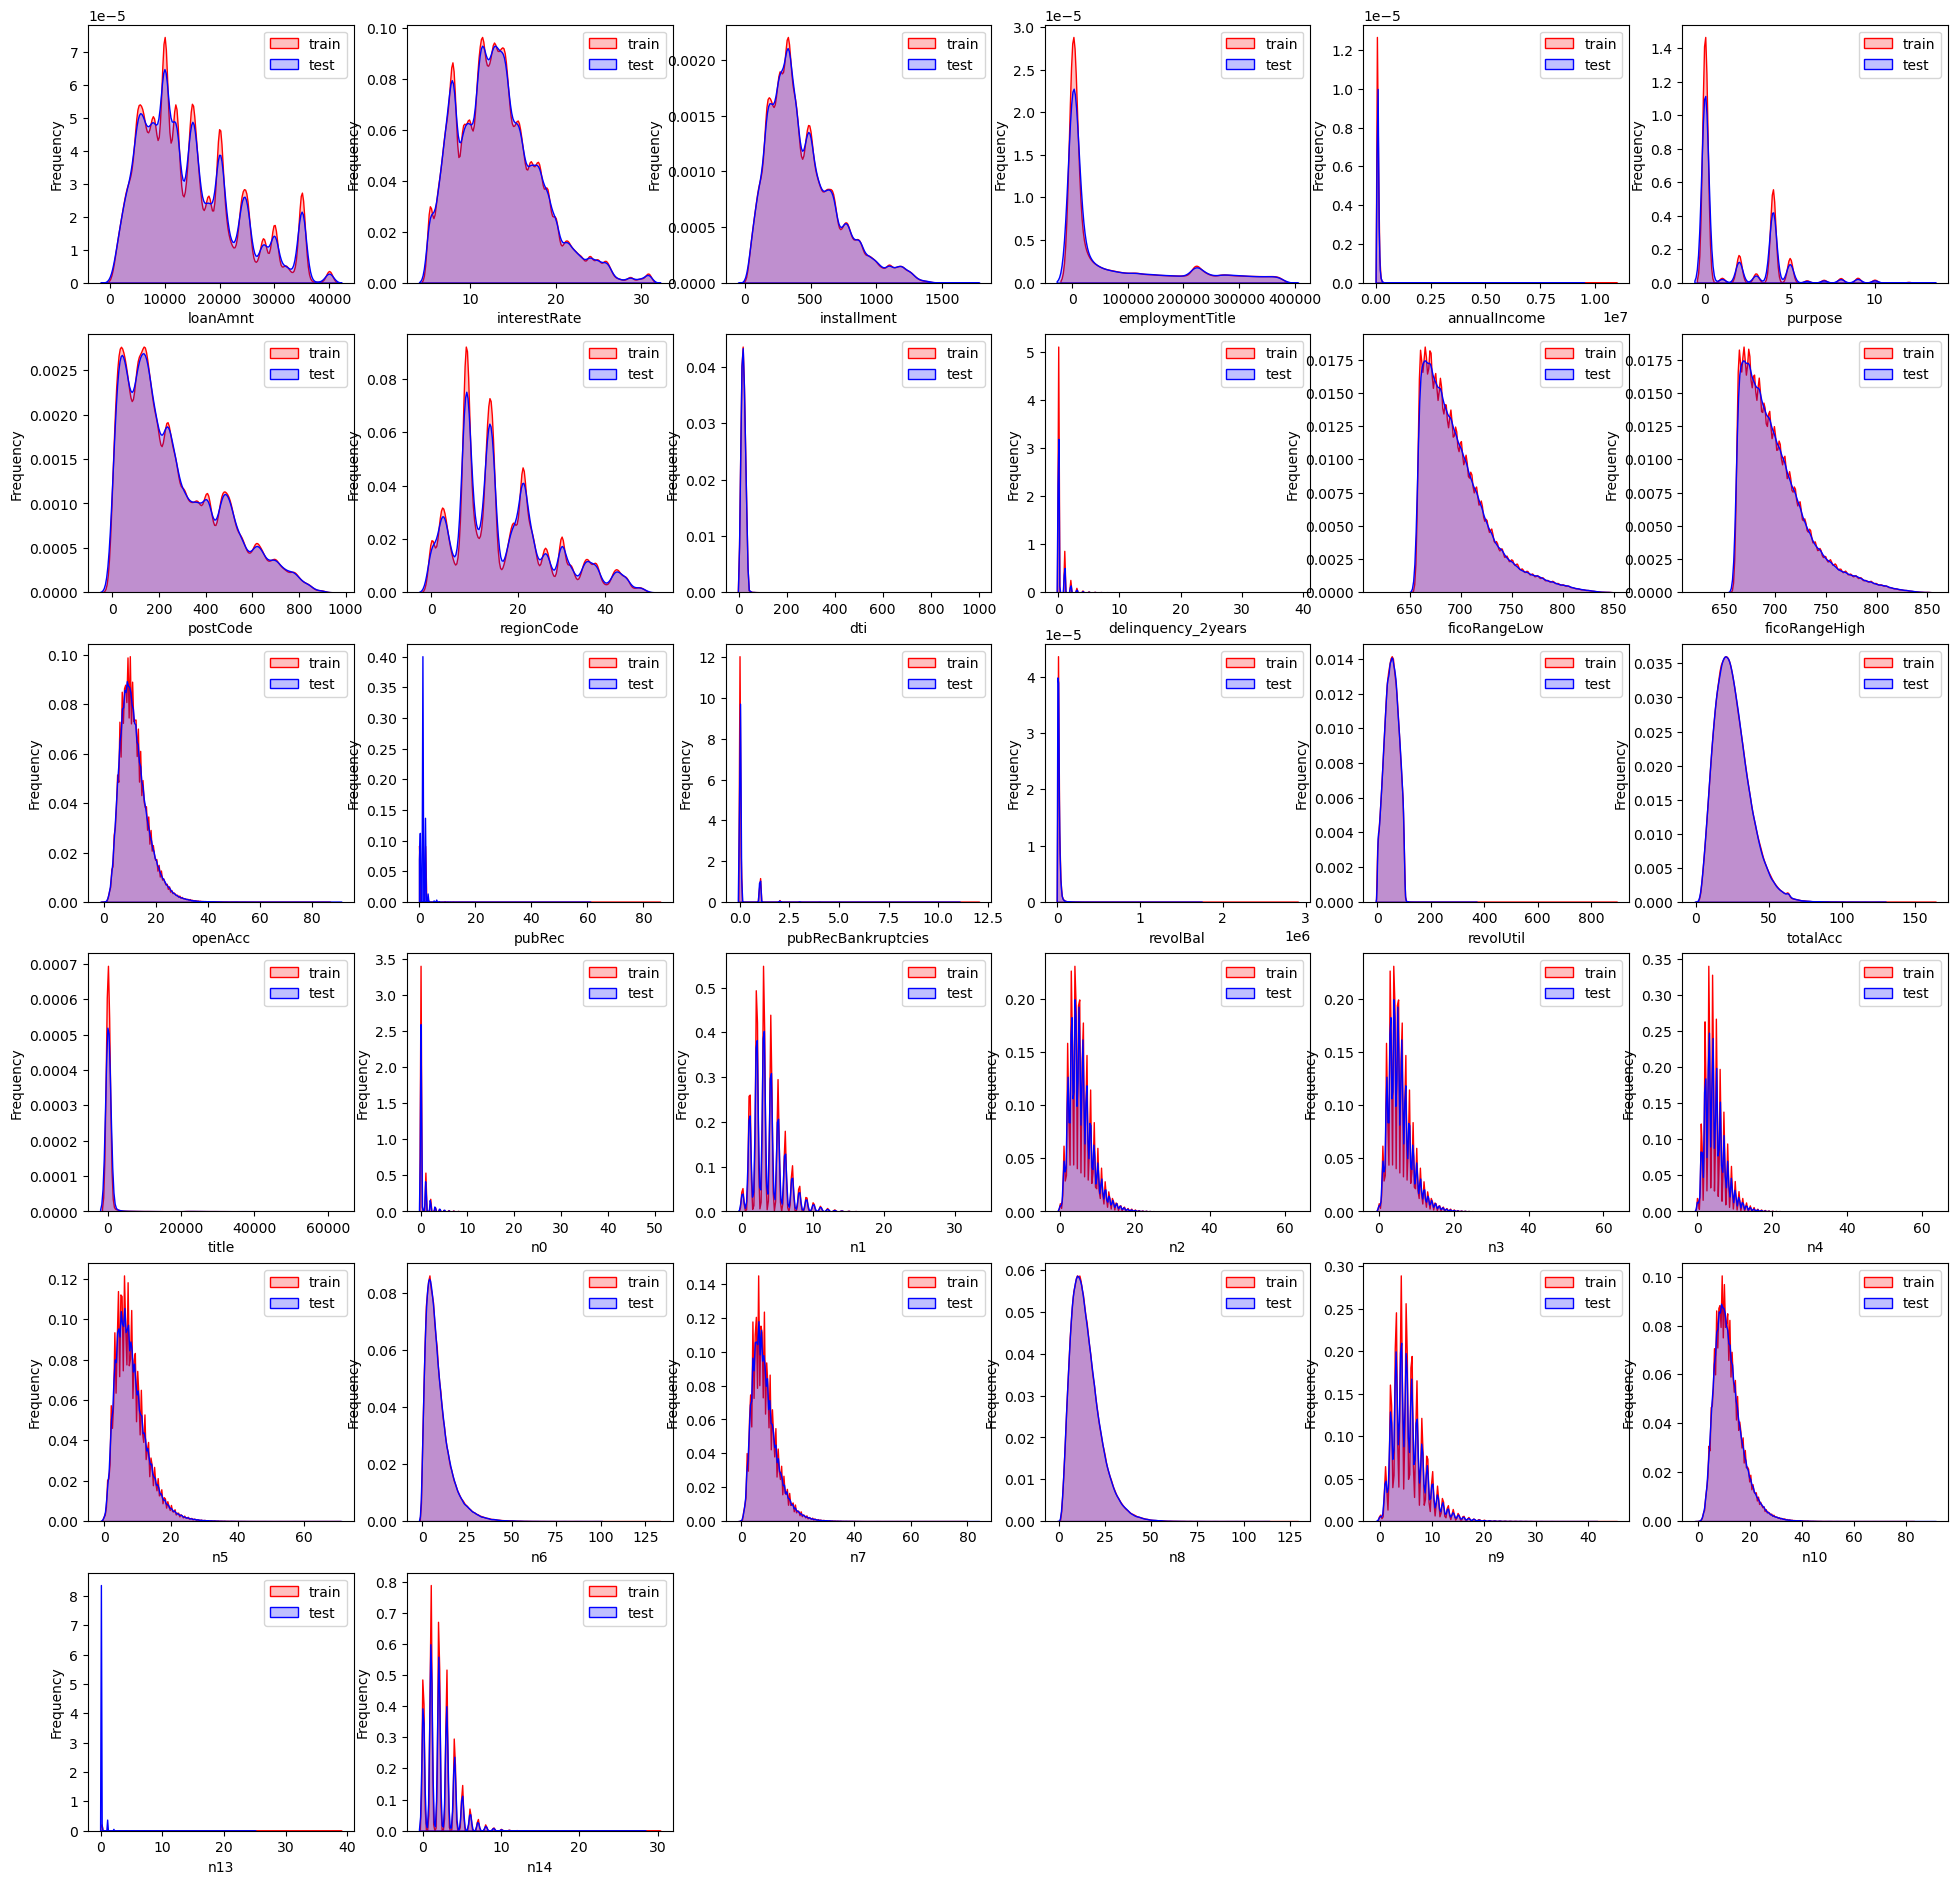

In [19]:
#对训练集与测试集数据进行可视化正态分布进行对比
#此处采用算法区分的连续型变量
dist_cols = 6
dist_rows = len(data_test_a[numerical_serial_fea].columns)
plt.figure(figsize=(4*dist_cols,4*dist_rows))

i=1
for col in data_test_a[numerical_serial_fea].columns:
    ax=plt.subplot(dist_rows,dist_cols,i)
    ax = sns.kdeplot(data_train[numerical_serial_fea][col], color="Red", shade=True)
    ax = sns.kdeplot(data_test_a[numerical_serial_fea][col], color="Blue", shade=True)
    ax.set_xlabel(col)
    ax.set_ylabel("Frequency")
    ax = ax.legend(["train","test"])
    
    i+=1
plt.show()

In [ ]:
#画正态分布图及QQ图
from scipy import stats
import numpy as np  # 新增导入

train_cols = 6
train_rows = len(data_train[numerical_serial_fea].columns)
plt.figure(figsize=(4*train_cols, 4*train_rows))

i = 0
for col in data_train[numerical_serial_fea].columns:
    # 子图1：分布图（直方图 + KDE + 正态拟合）
    i += 1
    ax = plt.subplot(train_rows, train_cols, i)
    sns.histplot(data_train[numerical_serial_fea][col], 
                 kde=True, 
                 stat='density', 
                 alpha=0.5, 
                 ax=ax)
    # 添加正态分布曲线
    mean = data_train[numerical_serial_fea][col].mean()
    std = data_train[numerical_serial_fea][col].std()
    xmin, xmax = ax.get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = stats.norm.pdf(x, mean, std)
    ax.plot(x, p, 'r', linewidth=2, label='Normal Fit')
    ax.set_title(f'{col} Distribution')
    ax.legend()
    
    # 子图2：QQ图
    i += 1
    ax = plt.subplot(train_rows, train_cols, i)
    res = stats.probplot(data_train[numerical_serial_fea][col], plot=ax)
    ax.set_title(f'{col} QQ Plot')

plt.tight_layout()
plt.show()
